In [4]:
import pandas as pd

In [ ]:
!pip install transformers

In [6]:
df = pd.read_csv('/content/result.csv', encoding='utf-8')

In [7]:
big_df = pd.read_csv('/content/more_data.csv', encoding='utf-8')

In [50]:
bigger_df = pd.read_csv('/content/bigger_data.csv', sep=';', encoding='utf-8')

In [9]:
df = df.drop(columns='Unnamed: 0')

In [31]:
big_df = big_df.drop(columns='Unnamed: 0')

In [53]:
bigger_df = bigger_df.drop(columns='Column1')

In [ ]:
bigger_df

In [55]:
sentences = bigger_df.tokens.values
labels = bigger_df.gender.values

In [56]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)
print('Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  MASK басса доброго крути MASK сегодня красиво сатива MASK вечер MASK мимо лечим лечим мокрого сухого принимай слабо дом боба засовы MASK всё MASK честь битов MASK облака энди мияги стиль пластик пламя MASK приведи бог музы MASK время песок ман MASK пора солнце MASK MASK тела туса MASK теле MASK видом ночью MASK MASK акелла MASK сегодня сегодня сегодня мои раста MASK панчи час чары чики нунчаки MASK санчо молча ночь MASK части тела погромче дыма MASK антанта ламба вдаль ламбо бланта типа ван дамм MASK битам инфаркта инферно MASK густо MASK MASK MASK момент MASK MASK MASK фейрверк тук тук MASK звук мои пацаны MASK круг раггамафин фоном фараонам братьям салам всем джа MASK баронам сегодня сегодня сегодня сегодня сегодня сегодня
Tokenized:  ['mask', 'бас', '##са', 'добро', '##го', 'к', '##ру', '##ти', 'mask', 'сегодня', 'к', '##рас', '##ив', '##о', 'са', '##тив', '##а', 'mask', 'вече', '##р', 'mask', 'ми', '##мо', 'ле', '##чим', 'ле', '##чим', 'мо', '##к', '##ро', '##го', 'су', 

In [57]:
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(
                        str(sent),                      
                        add_special_tokens = True)
    input_ids.append(encoded_sent)

Token indices sequence length is longer than the specified maximum sequence length for this model (606 > 512). Running this sequence through the model will result in indexing errors


In [58]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 256
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN , truncating="post", padding="post")

In [59]:
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [60]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,test_size=0.1)

In [17]:
import torch

In [61]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [62]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [63]:
optimizer = AdamW(model.parameters(), lr = 2e-5)

In [64]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [65]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (105879, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [66]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [67]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [68]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
acc_list = []
ep_list = []

In [69]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    acc_list.append(eval_accuracy/nb_eval_steps)
    ep_list.append(epoch_i + 1)


print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of     85.    Elapsed: 0:00:58.
  Batch    80  of     85.    Elapsed: 0:01:55.

  Average training loss: 0.66
  Training epcoh took: 0:02:01

Running Validation...
  Accuracy: 0.70
  Validation took: 0:00:05

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     85.    Elapsed: 0:00:57.
  Batch    80  of     85.    Elapsed: 0:01:54.

  Average training loss: 0.52
  Training epcoh took: 0:02:00

Running Validation...
  Accuracy: 0.79
  Validation took: 0:00:05

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     85.    Elapsed: 0:00:57.
  Batch    80  of     85.    Elapsed: 0:01:54.

  Average training loss: 0.36
  Training epcoh took: 0:02:00

Running Validation...
  Accuracy: 0.82
  Validation took: 0:00:05

Training complete!


In [ ]:
torch.cuda.empty_cache() 

In [70]:
acc_list

[0.546875,
 0.5390625,
 0.578125,
 0.5803571428571429,
 0.6651785714285714,
 0.6607142857142857,
 0.7,
 0.7947916666666667,
 0.825]

In [72]:
data_size = [1000, 1000, 1000, 2000, 2000, 2000, 3000, 3000, 3000]

In [71]:
stats = pd.DataFrame(columns=['epoch', 'acc', 'data_size'])

In [73]:
stats['data_size'] = data_size
stats['epoch'] = ep_list
stats['acc'] = acc_list

In [74]:
stats

,epoch,acc,data_size
0,1,0.546875,1000
1,2,0.539062,1000
2,3,0.578125,1000
3,1,0.580357,2000
4,2,0.665179,2000
5,3,0.660714,2000
6,1,0.700000,3000
7,2,0.794792,3000
8,3,0.825000,3000


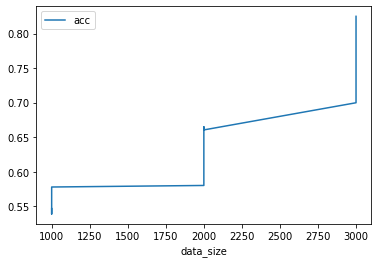

In [78]:
stats.plot(y='acc', x='data_size')